In [1]:
import sys
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

/home/allen/anaconda3/envs/dlcv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    "train_batchsz" : 32,
    "epoch" : 150,
    "lr" : 2.e-5,
    "betas" : (0., 0.999),
    "mnistm_path" : "/data/dlcv/hw2/hw2_data/digits/mnistm/",
    "device" :  "cuda" if torch.cuda.is_available() else "cpu",
    "numofclass" : 10,
    "maxT" : 1000,
    "beta_min" : 1.e-4,
    "beta_max" : 2.e-2
}
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
if config["device"] == "cuda":
    torch.cuda.set_device(2)
print('Device used :', config["device"])

Device used : cuda


In [3]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

same_seeds(7777)

In [4]:
class DigitDataset(Dataset):
    def __init__(self, datapath, csvpath=None, transform=None) -> None:
        self.data = []
        if os.path.exists(datapath):
            if csvpath is None:
                filenames = glob.glob(os.path.join(datapath, "*"))
                for filename in filenames:
                    self.data.append((filename, ))
            elif os.path.exists(csvpath):
                df = pd.read_csv(csvpath)
                self.data = [(os.path.join(datapath, name), label) for name, label in zip(df["image_name"], df["label"])]
            else:
                print("Can't find {}".format(csvpath))
                exit(-1)
        else:
            print("Can't find {}".format(datapath))
            exit(-1)
        self.len = len(self.data)
        self.transform = transform

    def __getitem__(self, index):
        img_fn, label = self.data[index]
        img = Image.open(img_fn)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return self.len

In [5]:
# modidied from https://github.com/dome272/Diffusion-Models-pytorch
class WConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = None, residual = False) -> None:
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.wconv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )
    def forward(self, x):
        return F.gelu(x + self.wconv(x)) if self.residual else self.wconv(x)

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class U_Down(nn.Module):
    def __init__(self, in_channels, out_channels, sz, emb_dim=256) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d((2, 2)),
            WConv(in_channels, in_channels, residual=True),
            WConv(in_channels, out_channels)
        ) #(bsz, out_channels, sz // 2, sz // 2)
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels)
        )
        self.attention = SelfAttention(out_channels, sz // 2)
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        ret = self.attention(x + emb)
        return ret

class U_Up(nn.Module):
    def __init__(self, in_channels, out_channels, sz, emb_dim=256) -> None:
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.conv = nn.Sequential(
            WConv(2*in_channels, 2*in_channels, residual=True),
            WConv(2*in_channels, out_channels)
        ) #(bsz, out_channels, 2 * sz, 2 * sz)
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels)
        )
        self.attention = SelfAttention(out_channels, sz * 2)
    def forward(self, x, skip_x, t):
        x = self.upsample(x) #(bsz, in_c, 2*sz, 2*sz)
        cat_x = torch.cat([skip_x, x], dim=1) #(bsz, 2*in_c, 2*sz, 2*sz)
        x = self.conv(cat_x) #(bsz, out_c, 2*sz, 2*sz)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        ret = self.attention(x + emb)
        return ret

In [6]:
class Unet(nn.Module):
    def __init__(self, feature_sz=28, emb_dim=256, numofclass=config["numofclass"]) -> None:
        super().__init__()
        self.emb_dim = emb_dim
        self.down_channels = [(64, 128), (128, 128)] #(in_channel, out_channel)
        self.up_channels = [(128, 64), (64, 64)] #(in_channel, out_channel)
        self.label_emb = nn.Embedding(numofclass, emb_dim)
        self.conv1 = WConv(in_channels=3, out_channels=64)
        self.down_layers = nn.ModuleList([U_Down(in_channels=i, out_channels=j, sz=feature_sz // (2 ** k)) for k, (i, j) in enumerate(self.down_channels)])
        self.bottom = nn.Sequential(
            WConv(in_channels=128, out_channels=256),
            WConv(in_channels=256, out_channels=256),
            WConv(in_channels=256, out_channels=128)
        )
        self.up_layers = nn.ModuleList([U_Up(in_channels=i, out_channels=j, sz=feature_sz // 2 ** (len(self.up_channels) - k)) for k, (i, j) in enumerate(self.up_channels)])
        self.out = nn.Conv2d(64, 3, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=config["device"]).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc #(bsz, channels)
    
    def forward(self, x, t, label):
        #embedding time and label
        t = t.unsqueeze(-1).float()
        t = self.pos_encoding(t, self.emb_dim) #(bsz, emb_dim)
        if label is not None:
            t += self.label_emb(label) #(bsz, emb_dim)
        x1 = self.conv1(x)
        skip_x = [x1]
        cur_flow = x1
        for idx, down_layer in enumerate(self.down_layers):
            cur_flow = down_layer(cur_flow, t)
            if idx < len(self.down_layers) - 1:
                skip_x.append(cur_flow)
        cur_flow = self.bottom(cur_flow) #(bsz, 128, 7, 7)
        for idx, up_layer in enumerate(self.up_layers):
            cur_flow = up_layer(cur_flow, skip_x[-(idx+1)], t)
        return self.out(cur_flow)

In [7]:
def imshow(img):
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to {}'.format(checkpoint_path))
def load_checkpoint(checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    return checkpoint["model_state_dict"], checkpoint["optimizer_state_dict"]

In [8]:
class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


In [9]:
import copy
class DiffusionModel():
    def __init__(self, checkpointpath=None) -> None:
        self.model = Unet().to(config["device"])
        # print(self.model)
        self.opt = optim.AdamW(self.model.parameters(), lr=config["lr"])
        self.train_loader = DataLoader(DigitDataset(datapath=os.path.join(config["mnistm_path"], "data"), csvpath=os.path.join(config["mnistm_path"], "train.csv"), transform=train_transforms),
                                        batch_size=config["train_batchsz"], shuffle=True, pin_memory=True)
        self.criterion = nn.MSELoss()
        # self.alpha_hat, self.beta = self.LinearSchedule()
        self.alpha_hat, self.beta = self.CosineSchedule()
        self.fix_noise = torch.randn((10, 10, 3, 28, 28)).to(config["device"]) #(digits, numperdigits, c, h, w)

        if checkpointpath is not None and os.path.exists(checkpointpath):
            m_checkpoint, o_checkpoint = load_checkpoint(checkpointpath, device=config["device"])
            self.model.load_state_dict(m_checkpoint)
            self.opt.load_state_dict(o_checkpoint)
            print("load model from {}".format(checkpointpath))


    def LinearSchedule(self):
        beta = torch.linspace(config["beta_min"], config["beta_max"], steps=config["maxT"])
        alpha = 1 - beta
        alpha_hat = torch.cumprod(alpha, dim=0)
        #index start at 1
        beta = torch.cat((torch.tensor([0]), beta), dim=0)
        alpha_hat = torch.cat((torch.tensor([0]), alpha_hat))
        return alpha_hat, beta
    
    def CosineSchedule(self):
        s = 8.e-3
        t = torch.arange(config["maxT"] + 1)
        f = torch.cos((torch.pi / 2) * (t / t.shape[0] + s) / (1 + s)) ** 2
        alpha_hat = f / f[0]
        alpha_hat_shiftright = torch.roll(alpha_hat, 1, dims=0)
        alpha_hat_shiftright[0] = 1
        beta = 1 - alpha_hat / alpha_hat_shiftright
        return alpha_hat, beta

    def Sample_t(self, n):
        return torch.randint(low=1, high=config["maxT"], size=(n,)).long()

    def AddNoise(self, x0, t):
        alpha_t_hat = self.alpha_hat[t][:, None, None, None]
        eps = torch.randn_like(x0)
        return torch.sqrt(alpha_t_hat) * x0 + torch.sqrt(1 - alpha_t_hat) * eps, eps

    def testnoise(self):
        img, label = next(iter(self.train_loader))
        noise_img = [img]
        for t in range(100, config["maxT"] + 1, 100):
            t_tensor = torch.tensor([t], dtype=torch.long)
            noise_img.append(self.AddNoise(img, t_tensor)[0])
        imshow(torchvision.utils.make_grid(torch.cat(noise_img, dim=0), nrow = len(noise_img), padding=0))

    def Sample(self, ep=None):
        self.model.eval()
        cfg_weight = 5.
        img_list = []
        with torch.no_grad():
            for digit in range(0, 10):
                img = self.fix_noise[digit].clone().detach() #(10, 3, 28, 28)
                digit_tensor = digit * torch.ones((img.shape[0],), dtype=torch.long).to(config["device"])
                for t in range(config["maxT"], 0, -1):
                    t_tensor = t * torch.ones((img.shape[0], ), dtype=torch.long).to(config["device"]) #(10,)
                    cond_noise = self.model(img, t_tensor, digit_tensor)
                    uncond_noise = self.model(img, t_tensor, None)
                    noise = torch.lerp(uncond_noise, cond_noise, cfg_weight)
                    alpha_t = (1 - self.beta[t_tensor])[:, None, None, None].to(config["device"])
                    alpha_t_hat = self.alpha_hat[t_tensor][:, None, None, None].to(config["device"])
                    sigma_t = torch.sqrt(self.beta[t_tensor])[:, None, None, None].to(config["device"])
                    img = (img - ((1 - alpha_t) / torch.sqrt(1 - alpha_t_hat)) * noise) / torch.sqrt(alpha_t)
                    if t > 1 :
                        img += sigma_t * torch.randn_like(img)
                img_list.append(img)
            img_list = torch.cat(img_list, dim=0).cpu()
        grid_img = torchvision.utils.make_grid(img_list, nrow=10, padding=0)
        if ep is not None:
            grid_img = (grid_img + 1) / 2.0
            torchvision.utils.save_image(grid_img, os.path.join("/data/allen/digitsgrid/", "diff_ep{}.png".format(ep)))
        else:
            imshow(grid_img)

    def ReportImg(self):
        self.model.eval()
        cfg_weight = 5.
        img_list = []
        firstzero = [self.fix_noise[0,0].clone().detach().cpu()]
        with torch.no_grad():
            for digit in range(0, 10):
                img = self.fix_noise[digit].clone().detach() #(10, 3, 28, 28)
                digit_tensor = digit * torch.ones((img.shape[0],), dtype=torch.long).to(config["device"])
                for t in range(config["maxT"], 0, -1):
                    t_tensor = t * torch.ones((img.shape[0], ), dtype=torch.long).to(config["device"]) #(10,)
                    cond_noise = self.model(img, t_tensor, digit_tensor)
                    uncond_noise = self.model(img, t_tensor, None)
                    noise = torch.lerp(uncond_noise, cond_noise, cfg_weight)
                    alpha_t = (1 - self.beta[t_tensor])[:, None, None, None].to(config["device"])
                    alpha_t_hat = self.alpha_hat[t_tensor][:, None, None, None].to(config["device"])
                    sigma_t = torch.sqrt(self.beta[t_tensor])[:, None, None, None].to(config["device"])
                    img = (img - ((1 - alpha_t) / torch.sqrt(1 - alpha_t_hat)) * noise) / torch.sqrt(alpha_t)
                    if t > 1 :
                        img += sigma_t * torch.randn_like(img)
                    if digit == 0 and (t - 1) % 200 == 0:
                        firstzero.append(img[0].clone().detach().cpu())
                img_list.append(img)
            img_list = torch.cat(img_list, dim=0).cpu()
        grid_img = torchvision.utils.make_grid(img_list, nrow=10, padding=0)
        zero_img = torchvision.utils.make_grid(firstzero, padding=0)
        imshow(grid_img)
        imshow(zero_img)
                
    def Train(self):
        self.ema = EMA(0.995)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        for ep in range(config["epoch"]):
            self.model.train()
            total_loss = 0.
            for idx, (x0, label) in enumerate(self.train_loader):
                t = self.Sample_t(x0.shape[0]) #(bsz,)
                xt, eps = self.AddNoise(x0, t)
                xt, label, t = xt.to(config["device"]), label.to(config["device"]), t.to(config["device"]) #(bsz,3,28,28), (bsz,1), (bsz,)
                if np.random.random() < 0.1:
                    label = None
                # print("input shape", xt.shape, label.shape, t.shape)
                predict_eps = self.model(xt, t, label)
                loss = self.criterion(eps.to(config["device"]), predict_eps)
                total_loss += loss.item()
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                self.ema.step_ema(self.ema_model, self.model)
            print("Epoch[{}/{}] loss : {:.6f}".format(ep + 1, config["epoch"], total_loss / idx))
            if (ep + 1) % 5 == 0:
                save_checkpoint(os.path.join("/data/allen/hw2model/", "diffusion_ep{}.pth".format(ep + 1)), self.model, self.opt)
                self.Sample(ep + 1)

In [10]:
diffusion = DiffusionModel()
diffusion.Train()

Epoch[1/150] loss : 0.241940
Epoch[2/150] loss : 0.127361
Epoch[3/150] loss : 0.107629
Epoch[4/150] loss : 0.097311
Epoch[5/150] loss : 0.091521
model saved to /data/allen/hw2model/diffusion_ep5.pth
Epoch[6/150] loss : 0.086962
Epoch[7/150] loss : 0.082554
Epoch[8/150] loss : 0.079845
Epoch[9/150] loss : 0.077707
Epoch[10/150] loss : 0.075619
model saved to /data/allen/hw2model/diffusion_ep10.pth
Epoch[11/150] loss : 0.073714
Epoch[12/150] loss : 0.072445
Epoch[13/150] loss : 0.071884
Epoch[14/150] loss : 0.069966
Epoch[15/150] loss : 0.069148
model saved to /data/allen/hw2model/diffusion_ep15.pth
Epoch[16/150] loss : 0.068294
Epoch[17/150] loss : 0.067062
Epoch[18/150] loss : 0.066226
Epoch[19/150] loss : 0.065625
Epoch[20/150] loss : 0.064487
model saved to /data/allen/hw2model/diffusion_ep20.pth
Epoch[21/150] loss : 0.064434
Epoch[22/150] loss : 0.063644
Epoch[23/150] loss : 0.063368
Epoch[24/150] loss : 0.063251
Epoch[25/150] loss : 0.061910
model saved to /data/allen/hw2model/diff

load model from /data/allen/hw2model/hw2_2.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


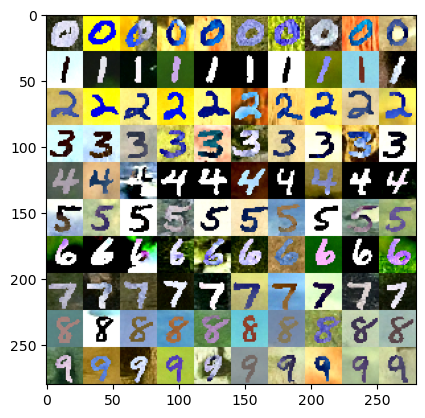

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


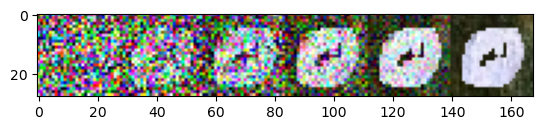

In [10]:
diffusion = DiffusionModel(checkpointpath="/data/allen/hw2model/hw2_2.pth")
diffusion.ReportImg()